# Track user event data

In [1]:
from database_workers.Neo4j_User_Worker import User_Worker
user_worker = User_Worker()
users = user_worker.get_unique_user_ids()
user_worker.close()
len(users)

42

In [2]:
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
events_all = []
for user in users:
    events_all.append(event_worker.get_user_events(user_id=user))
event_worker.close()

In [3]:
# An example of the events
events_all[0]

# Turn string timestamp into datetime object and put that back into the event object
# from datetime import datetime

# for events in events_all:
#     for event in events:
#         event['timestamp'] = datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')

# events_all[0]

[{'action': 'mounted',
  'page': 'App',
  'timestamp': '2023-06-04T17:17:59.625Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:17:59.625Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:03.003Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:21.387Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'Home',
  'timestamp': '2023-06-04T17:20:55.916Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'close_player',
  'page': 'preferences',
  'timestamp': '2023-06-04T17:28:14.890Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'page_open',
  'page': 'preferences',
  'timestamp': '2023-06-04T17:43:10.780Z',
  'user': 'AN57y8tcIThEeqeo9Uq1s7pHzM03'},
 {'action': 'player_view_open',
  'page': 'preferences',
  'timestamp': '2023-06-04

In [4]:
from datetime import datetime, timedelta

def split_into_sessions(events_all, threshold_minutes):
    all_sessions = []
    idle_threshold = timedelta(minutes=threshold_minutes)

    for events in events_all:
        sessions = []
        current_session = []

        for i, event in enumerate(events):
            current_timestamp = datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')

            if i == 0:
                current_session.append(event)
            else:
                previous_timestamp = datetime.strptime(events[i-1]['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ')
                time_diff = current_timestamp - previous_timestamp

                if time_diff <= idle_threshold:
                    current_session.append(event)
                else:
                    sessions.append(current_session)
                    current_session = [event]

        if current_session:
            sessions.append(current_session)

        all_sessions.append(sessions)

    return all_sessions


In [5]:
threshold_minutes = 30  # Adjust this threshold as needed

sessions = split_into_sessions(events_all, threshold_minutes)

# Print the sessions' timestamps, users, and actions but with a nicer format
for filtered_sessions in sessions:
    for session in filtered_sessions:
        print([(datetime.strptime(event['timestamp'], '%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d %H:%M:%S'), event['user'], event['action']) for event in session])

[('2023-06-04 17:17:59', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:17:59', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:03', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:21', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:20:55', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:28:14', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'close_player'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), ('2023-06-04 17:43:10', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), ('2023-06-04 17:43:11', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'mounted'), ('2023-06-04 17:48:31', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'page_open'), ('2023-06-04 17:48:31', 'AN57y8tcIThEeqeo9Uq1s7pHzM03', 'player_view_open'), (

In [6]:
# Count the number of sessions for each user
num_sessions_per_user = [len(user_sessions) for user_sessions in sessions]

# Filter the sessions to only include users with fewer than 10 sessions
filtered_sessions = [user_sessions for user_sessions, num_sessions in zip(sessions, num_sessions_per_user) if num_sessions < 10]

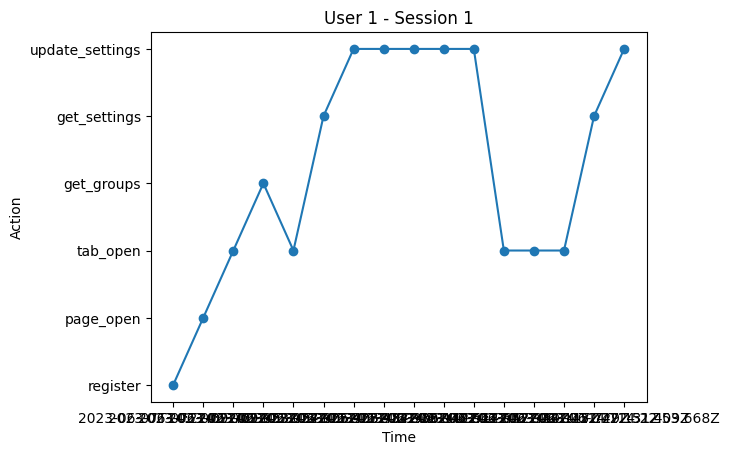

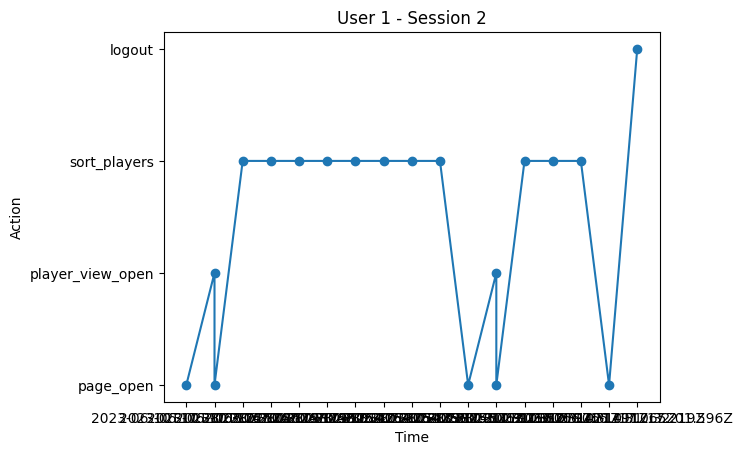

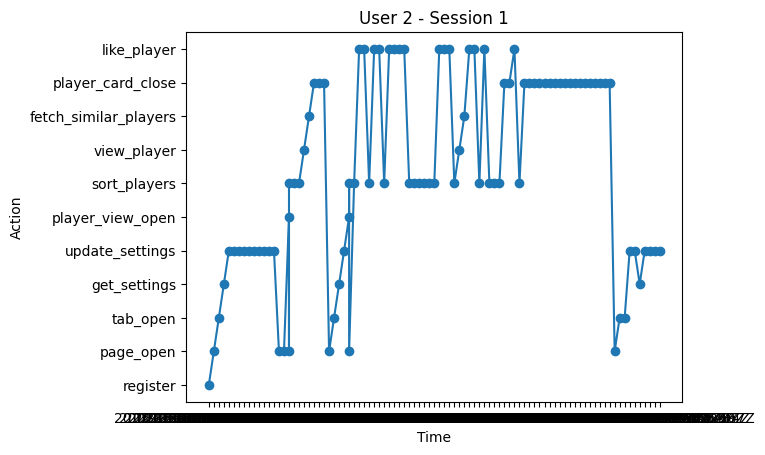

In [7]:
import matplotlib.pyplot as plt

# Split events into sessions
sessions_all = split_into_sessions(events_all[7:], 30)

# For each user
for i, sessions in enumerate(sessions_all[:2]):
    # For each session
    for j, session in enumerate(sessions[:2]):
        # Create a new figure for each session
        plt.figure()

        # Extract the timestamps and actions from the session
        timestamps = [event['timestamp'] for event in session]
        actions = [event['action'] for event in session]

        # Create a line plot with time on the x-axis and action on the y-axis
        plt.plot(timestamps, actions, marker='o')

        # Set the title and labels
        plt.title(f'User {i+1} - Session {j+1}')
        plt.xlabel('Time')
        plt.ylabel('Action')

        # Show the plot
        plt.show()


In [8]:
import plotly.graph_objects as go
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Flatten the list of sessions to get a list of all events
all_events_flat = [event for user_sessions in filtered_sessions for session in user_sessions for event in session]

# Create a list of all transitions
transitions = [(all_events_flat[i]['action'], all_events_flat[i+1]['action']) for i in range(len(all_events_flat)-1)]

# Count the frequency of each transition
transition_counts = Counter(transitions)

# Filter out transitions with a count of less than 10
transition_counts = {k: v for k, v in transition_counts.items() if v >= 30}

# Get the unique events and create a dictionary mapping events to indices
unique_events = list(set([event for transition in transitions for event in transition]))
event_to_index = {event: i for i, event in enumerate(unique_events)}

# Convert the transition counts to a format suitable for plotly
source = [event_to_index[a] for a, b in transition_counts.keys()]
target = [event_to_index[b] for a, b in transition_counts.keys()]
value = list(transition_counts.values())

# Scale the values to increase the thickness of the links
value = [v * 5 for v in value]  # Adjust the multiplier as needed

# Count the frequency of each event
event_counts = Counter([event['action'] for event in all_events_flat])

# Create a color scale based on the event frequencies
color_scale = np.interp([event_counts[event] for event in unique_events], (min(event_counts.values()), max(event_counts.values())), (0, 1))

# Convert the color scale to hexadecimal color codes
node_color = [mcolors.to_hex(plt.cm.jet(c)) for c in color_scale]  # Use the jet colormap

# Set the color of each link to match the color of the source node
link_color = [node_color[s] for s in source]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 50,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = unique_events,
      color = node_color
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = link_color
  ))])

fig.update_layout(title_text="Most Likely Event-to-Event Workflows", font_size=10)
fig.show()


# Check the following
- Most clicked events 
- Most clicked players - explore info about those players
- Most liked players - explore info about those players
- Most recommended matches maybe? 

In [9]:
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_players = event_worker.get_view_player_timestamps()
player_views = event_worker.get_player_view_open_timestamps()
event_worker.close()
print(len(view_players))
print(len(player_views))

729
746


We have more player views. However, only view_player has the player that was viewed.

**So we use the view_player.** 
- Player views: when a browsing page opens a player.
- View players: when an opened page has a player in the ID. This must have been less effective.

In [10]:
# Check view_player counts
from database_workers.Neo4j_Event_Worker import Event_Worker
event_worker = Event_Worker()
view_counts = event_worker.count_view_player()
like_counts = event_worker.count_like_player()
event_worker.close()
len(view_counts)

45

In [11]:
view_counts

{'Daniil Medvedev': {'total': 41,
  'preferences': 1,
  'browsing': 1,
  'browsing/player': 34,
  'browsing/parameter': 5},
 'Elise Mertens': {'total': 34, 'preferences': 4, 'browsing/player': 30},
 'Tallon Griekspoor': {'total': 17,
  'browsing/player': 14,
  'browsing/parameter': 3},
 'Felix Auger-Aliassime': {'total': 12, 'browsing/player': 12},
 'Qinwen Zheng': {'total': 11, 'browsing': 1, 'browsing/player': 10},
 'Jannik Sinner': {'total': 10, 'browsing/player': 10},
 'Belinda Bencic': {'total': 8, 'browsing/player': 8},
 'Alexander Bublik': {'total': 7, 'browsing/player': 7},
 'Alex de Minaur': {'total': 6, 'browsing/player': 6},
 'Emil Ruusuvuori': {'total': 5, 'browsing/player': 5},
 'Karolina Muchova': {'total': 4, 'browsing/player': 4},
 'Bianca Andreescu': {'total': 4, 'browsing/player': 4},
 'Liudmila Samsonova': {'total': 4, 'browsing/player': 4},
 'Varvara Gracheva': {'total': 3, 'browsing': 1, 'browsing/player': 2},
 'Maxime Cressy': {'total': 3, 'browsing/player': 2, 'b

In [12]:
like_counts

{'Daniil Medvedev': {'total': 20,
  'browsing/player': 19,
  'browsing/parameter': 1},
 'Elise Mertens': {'total': 18,
  'preferences': 1,
  'browsing/player': 16,
  'browsing/parameter': 1},
 'Felix Auger-Aliassime': {'total': 14,
  'browsing/player': 10,
  'browsing/parameter': 4},
 'Alex de Minaur': {'total': 12,
  'browsing': 6,
  'browsing/player': 5,
  'browsing/parameter': 1},
 'Tallon Griekspoor': {'total': 12,
  'browsing/player': 8,
  'browsing/parameter': 4},
 'Alexander Bublik': {'total': 11, 'browsing': 7, 'browsing/player': 4},
 'Marin Cilic': {'total': 9, 'browsing/player': 5, 'browsing/parameter': 4},
 'Veronika Kudermetova': {'total': 7,
  'preferences': 2,
  'browsing/player': 4,
  'browsing/parameter': 1},
 'Victoria Azarenka': {'total': 7, 'browsing': 2, 'browsing/player': 5},
 'Qinwen Zheng': {'total': 6, 'browsing': 1, 'browsing/player': 5},
 'Milos Raonic': {'total': 6, 'browsing/player': 5, 'browsing/parameter': 1},
 'Borna Coric': {'total': 6, 'browsing/player'

## Describe player view and like counts

       total  preferences  browsing  browsing/player  browsing/parameter
count  45.00        45.00     45.00            45.00               45.00
mean    5.04         0.11      0.11             4.58                0.24
std     7.86         0.61      0.32             6.75                0.88
min     1.00         0.00      0.00             0.00                0.00
25%     2.00         0.00      0.00             2.00                0.00
50%     3.00         0.00      0.00             2.00                0.00
75%     4.00         0.00      0.00             4.00                0.00
max    41.00         4.00      1.00            34.00                5.00

Sum of all columns:
total                 227.0
preferences             5.0
browsing                5.0
browsing/player       206.0
browsing/parameter     11.0
dtype: float64


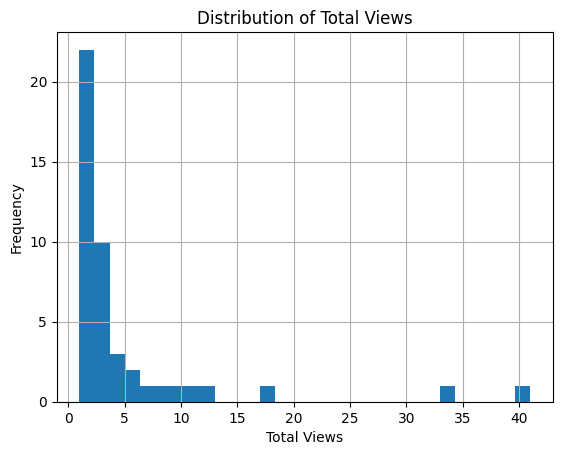

Daniil Medvedev          41.0
Elise Mertens            34.0
Tallon Griekspoor        17.0
Felix Auger-Aliassime    12.0
Qinwen Zheng             11.0
Jannik Sinner            10.0
Belinda Bencic            8.0
Alexander Bublik          7.0
Alex de Minaur            6.0
Emil Ruusuvuori           5.0
Name: total, dtype: float64


Daniil Medvedev               browsing/player
Elise Mertens                 browsing/player
Tallon Griekspoor             browsing/player
Felix Auger-Aliassime         browsing/player
Qinwen Zheng                  browsing/player
Jannik Sinner                 browsing/player
Belinda Bencic                browsing/player
Alexander Bublik              browsing/player
Alex de Minaur                browsing/player
Emil Ruusuvuori               browsing/player
Karolina Muchova              browsing/player
Bianca Andreescu              browsing/player
Liudmila Samsonova            browsing/player
Varvara Gracheva              browsing/player
Maxime Cressy                 browsing/player
Pablo Carreno Busta           browsing/player
Veronika Kudermetova          browsing/player
David Goffin                  browsing/player
Ugo Humbert                   browsing/player
Victoria Azarenka             browsing/player
Alec Deckers                  browsing/player
Roberto Bautista Agut         brow

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create dictionary
data = view_counts
df = pd.DataFrame(data).T
# Convert NaN to 0
df = df.fillna(0)

# Descriptive statistics to the nearest 0.01 
print(df.describe().round(2))

# Print the sums of all columns
print("\nSum of all columns:")
print(df.sum())

# Distribution Analysis
df['total'].hist(bins=30)
plt.title('Distribution of Total Views')
plt.xlabel('Total Views')
plt.ylabel('Frequency')
plt.show()

# Top viewed players
print(df['total'].nlargest(10))

# Page from which players are viewed most
df.drop('total', axis=1).idxmax(axis=1)


       total  browsing/player  browsing/parameter  preferences  browsing
count  59.00            59.00               59.00        59.00     59.00
mean    3.68             2.51                0.78         0.05      0.34
std     4.26             3.53                1.02         0.29      1.24
min     1.00             0.00                0.00         0.00      0.00
25%     1.00             1.00                0.00         0.00      0.00
50%     2.00             1.00                1.00         0.00      0.00
75%     4.50             3.50                1.00         0.00      0.00
max    20.00            19.00                4.00         2.00      7.00

Sum of all columns:
total                 217.0
browsing/player       148.0
browsing/parameter     46.0
preferences             3.0
browsing               20.0
dtype: float64


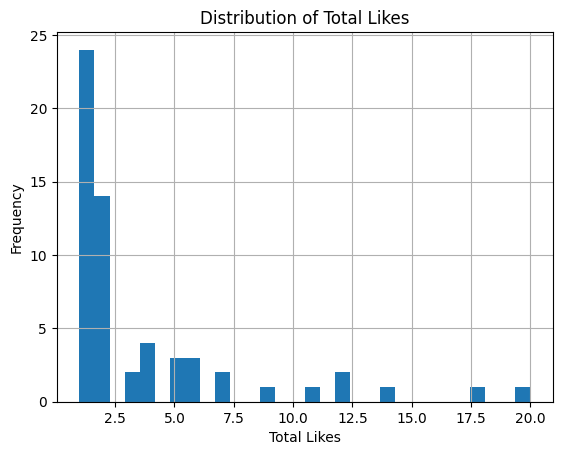

Daniil Medvedev          20.0
Elise Mertens            18.0
Felix Auger-Aliassime    14.0
Alex de Minaur           12.0
Tallon Griekspoor        12.0
Alexander Bublik         11.0
Marin Cilic               9.0
Veronika Kudermetova      7.0
Victoria Azarenka         7.0
Qinwen Zheng              6.0
Name: total, dtype: float64


Daniil Medvedev                  browsing/player
Elise Mertens                    browsing/player
Felix Auger-Aliassime            browsing/player
Alex de Minaur                          browsing
Tallon Griekspoor                browsing/player
Alexander Bublik                        browsing
Marin Cilic                      browsing/player
Veronika Kudermetova             browsing/player
Victoria Azarenka                browsing/player
Qinwen Zheng                     browsing/player
Milos Raonic                     browsing/player
Borna Coric                      browsing/player
Bianca Andreescu                 browsing/player
Miomir Kecmanovic                browsing/player
Emil Ruusuvuori                  browsing/player
Liudmila Samsonova            browsing/parameter
Belinda Bencic                   browsing/player
Karolina Muchova                 browsing/player
Tim van Rijthoven             browsing/parameter
Ekaterina Alexandrova            browsing/player
Botic van de Zandsch

In [14]:
# Create dictionary
data = like_counts
df = pd.DataFrame(data).T
# Convert NaN to 0
df = df.fillna(0)

# Descriptive statistics to the nearest 0.01 
print(df.describe().round(2))

# Print the sums of all columns
print("\nSum of all columns:")
print(df.sum())

# Distribution Analysis
df['total'].hist(bins=30)
plt.title('Distribution of Total Likes')
plt.xlabel('Total Likes')
plt.ylabel('Frequency')
plt.show()

# Top viewed players
print(df['total'].nlargest(10))

# Page from which players are viewed most
df.drop('total', axis=1).idxmax(axis=1)


## Get properties

In [15]:
from database_workers.Neo4j_Player_Worker import Player_Worker
player_names = list(like_counts.keys())
players = dict()

player_worker = Player_Worker()
for player in player_names:
    players[player] = player_worker.get_player_data(player)
player_worker.close()

players

{'Daniil Medvedev': {'name': 'Daniil Medvedev',
  'country': '',
  'rank': 2,
  'rank_level': 1,
  'previous_libema_winner': False,
  'status': 'Top 10',
  'experience': 3,
  'play_style': 'Counter puncher',
  'style': None,
  'age': 27,
  'height': 198,
  'favorite_shot': 'Return',
  'hand': 'Right-handed',
  'personality_tags': ['funny',
   'outspoken',
   'analytical',
   'unorthodox',
   'defensive baseliner'],
  'personality_long': "Medvedev is known for his counter-punching style and excellent defensive play. His flat and deep shots, combined with his exceptional court coverage, make him a tough player to beat. He's also known for his tactical intelligence, often adjusting his game plan mid-match to exploit his opponents' weaknesses.",
  'grass_advantage': False,
  'career_high_rank': 1,
  'years_on_tour': 9,
  'coach': 'Gilles Cervara',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/medvedev-full-2022-may.png',
  'gender': 'Male',
  'country_code': '',
  'care

In [16]:
sorted(list(players['Daniil Medvedev'].keys()))

['age',
 'career_high_rank',
 'career_high_year',
 'coach',
 'country',
 'country_code',
 'country_zone',
 'experience',
 'favorite_shot',
 'gender',
 'grass_advantage',
 'hand',
 'height',
 'image_url',
 'name',
 'personality_long',
 'personality_tags',
 'play_style',
 'previous_libema_winner',
 'rank',
 'rank_level',
 'status',
 'style',
 'years_on_tour']

## Correlation analysis

In [40]:
import seaborn as sns

# Convert dictionaries to pandas DataFrames
def correlation_analysis(interactions, players, interaction_type):
    idf_numeric = pd.DataFrame(interactions).T
    pdf_numeric = pd.DataFrame(players).T

    # Drop non_numeric columns
    idf_numeric = idf_numeric.drop(['browsing'], axis=1)
    pdf_numeric = pdf_numeric[['rank', 'age', 'height', 'career_high_rank', 'career_high_year', 'years_on_tour', 'grass_advantage', 'previous_libema_winner']]
    pdf_numeric['previous_libema_winner'] = pdf_numeric['previous_libema_winner'].astype(int)

    # Replace NaN with 0
    idf_numeric = idf_numeric.fillna(0)
    pdf_numeric = pdf_numeric.fillna(0)


    # Merge the two dataframes on the index (player name)
    df = pd.merge(pdf_numeric, idf_numeric['total'], left_index=True, right_index=True)

    # Convert columns to appropriate data types
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')

    # Check for linearity
    for col in df.columns:
        if col != 'total':
            sns.lmplot(x=col, y='total', data=df, line_kws={'color': 'red'})
            plt.title(f'{col} vs. {interaction_type}')
            plt.ylabel(interaction_type)

            # save the plot in ./plots
            plt.savefig(f'./plots/{col}_vs_{interaction_type}.png')
            plt.show()

    # Calculate correlation matrix
    correlation_matrix = df.corr('kendall')

    correlation_with_total = correlation_matrix['total'][:-1]
    print(correlation_with_total)

    # Now print them in order of overall magnitude (turn them all positive), from highest to lowest, , excluding the last one (which is the total itself)
    print()
    print(correlation_matrix['total'][:-1].abs().sort_values(ascending=False))

    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # Return the correlation with total as a DataFrame
    # Round to 3 digits after the decimal place
    correlation_with_total = correlation_with_total.round(3)
    return pd.DataFrame(correlation_with_total).sort_values(by='total', ascending=False).rename(columns={'total': interaction_type})


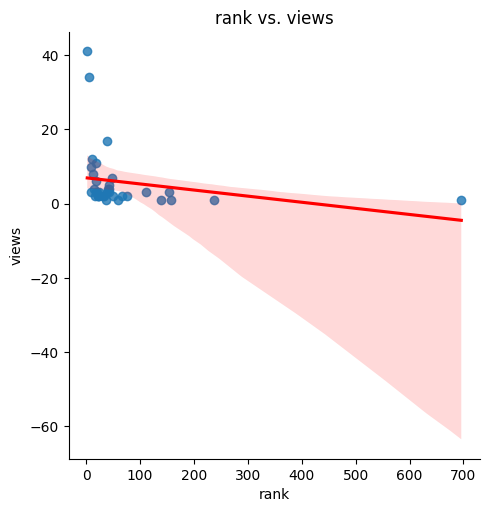

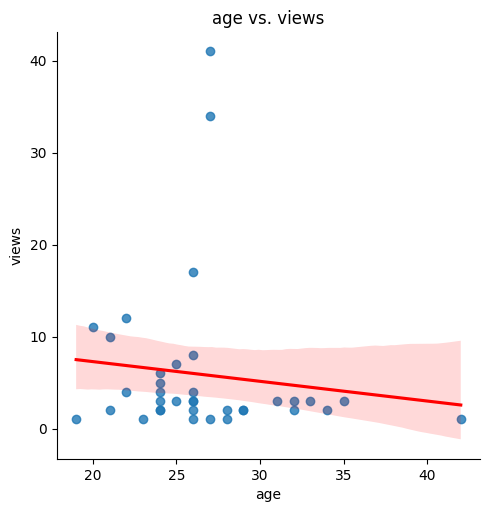

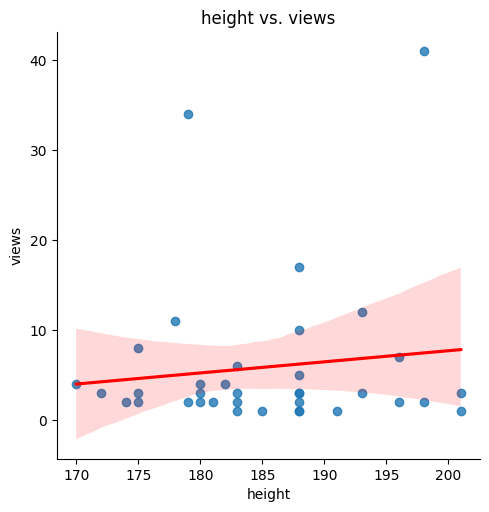

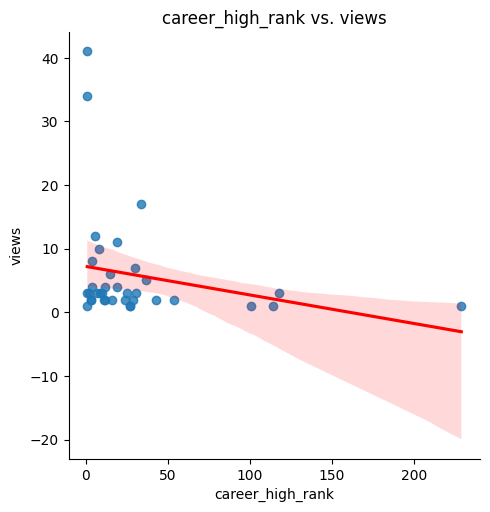

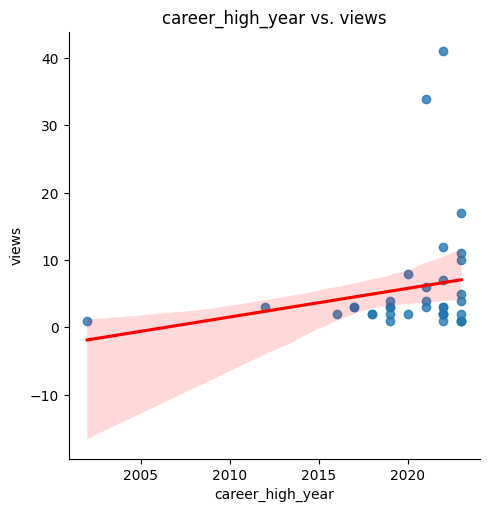

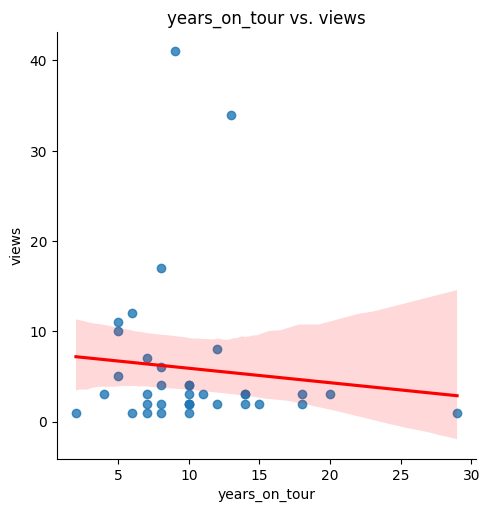

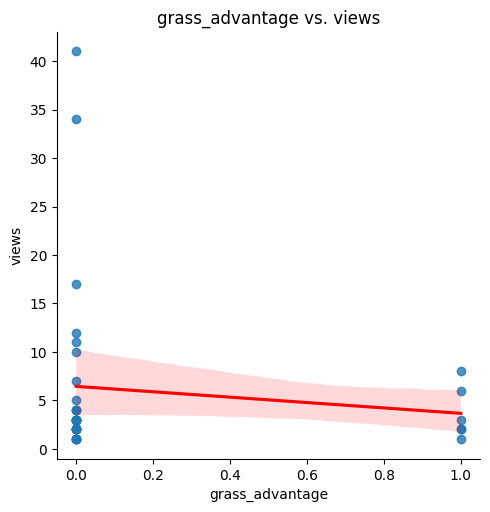

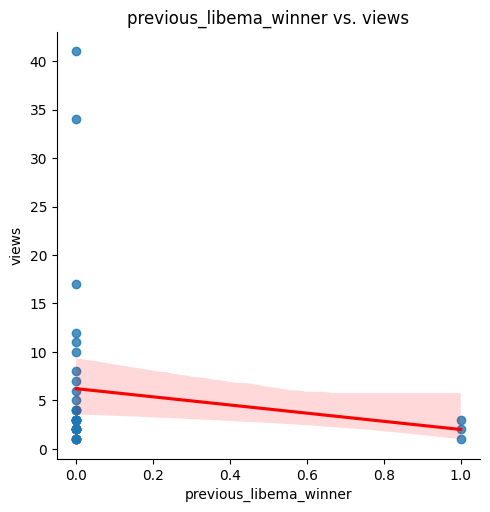

rank                     -0.461353
age                      -0.162487
height                   -0.061816
career_high_rank         -0.255830
career_high_year          0.137999
years_on_tour            -0.111364
grass_advantage          -0.059783
previous_libema_winner   -0.184612
Name: total, dtype: float64

rank                      0.461353
career_high_rank          0.255830
previous_libema_winner    0.184612
age                       0.162487
career_high_year          0.137999
years_on_tour             0.111364
height                    0.061816
grass_advantage           0.059783
Name: total, dtype: float64


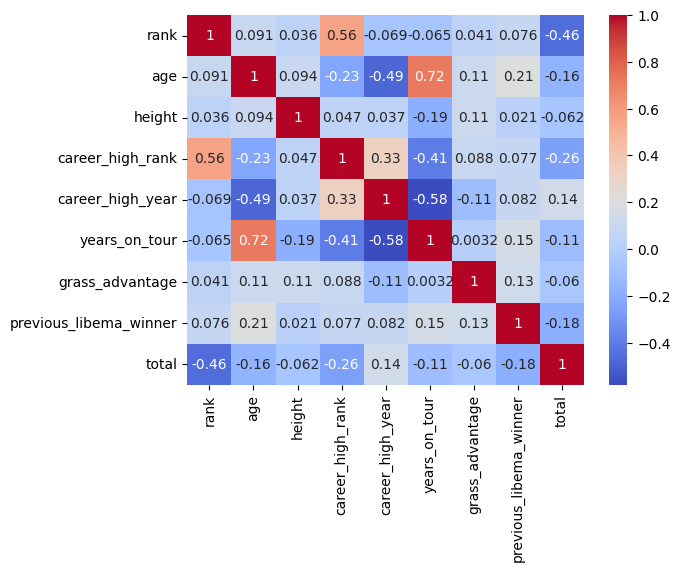

In [41]:
view_cors = correlation_analysis(view_counts, players, 'views')

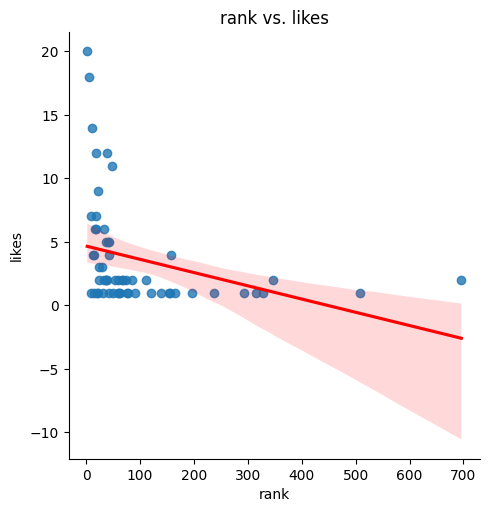

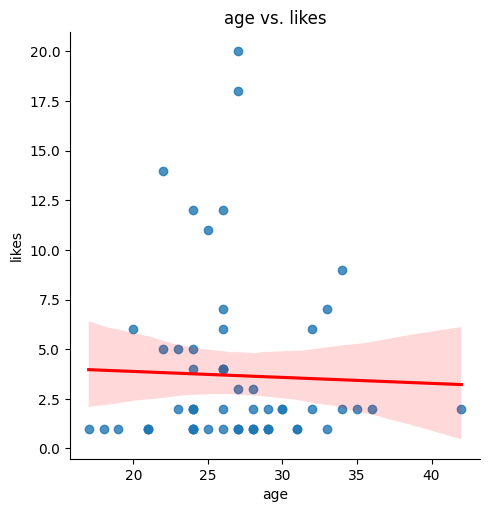

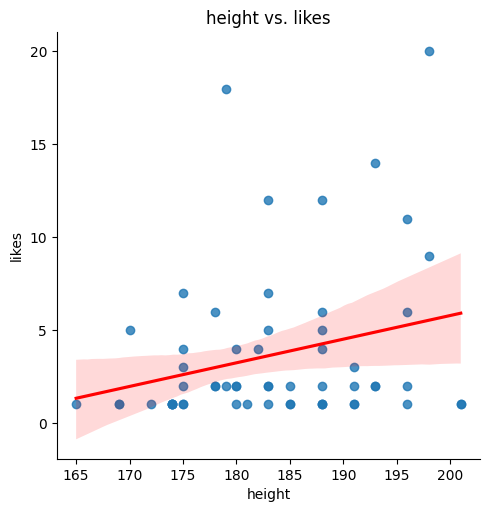

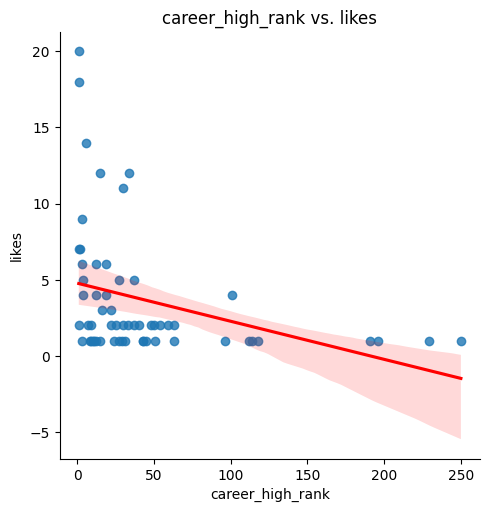

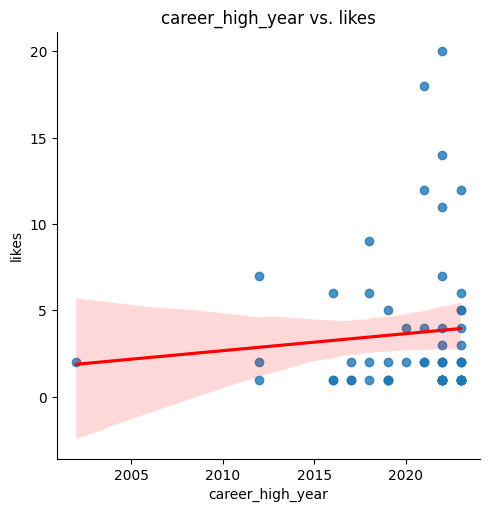

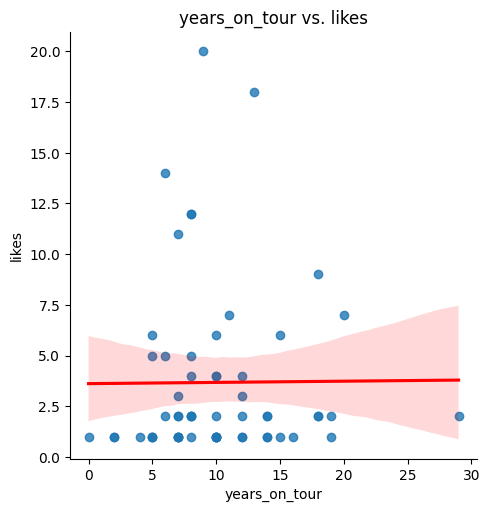

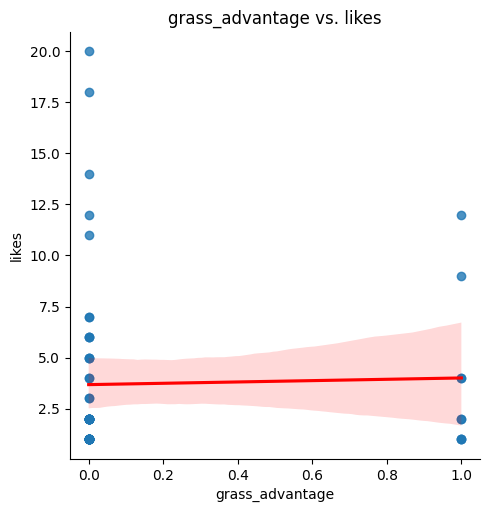

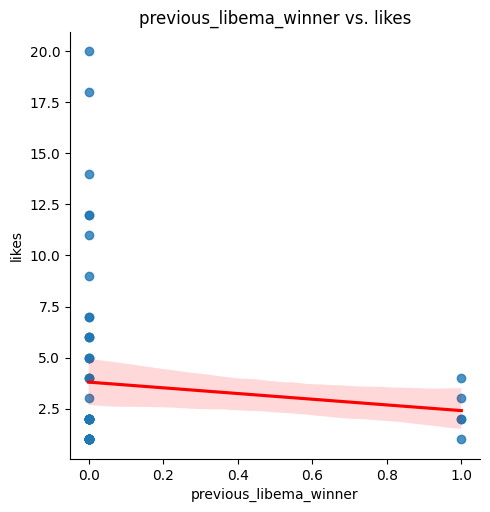

rank                     -0.450671
age                       0.016479
height                    0.194032
career_high_rank         -0.385790
career_high_year         -0.005097
years_on_tour             0.079950
grass_advantage           0.055598
previous_libema_winner    0.025041
Name: total, dtype: float64

rank                      0.450671
career_high_rank          0.385790
height                    0.194032
years_on_tour             0.079950
grass_advantage           0.055598
previous_libema_winner    0.025041
age                       0.016479
career_high_year          0.005097
Name: total, dtype: float64


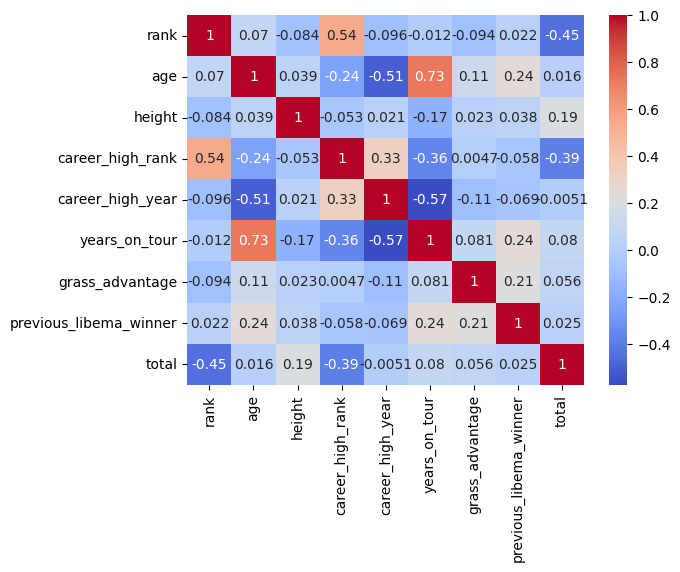

In [42]:
like_cors = correlation_analysis(like_counts, players, 'likes')

In [43]:
# Sort view cors from smallest to largest
view_cors

,views
career_high_year,0.138
grass_advantage,-0.060
height,-0.062
years_on_tour,-0.111
age,-0.162
previous_libema_winner,-0.185
career_high_rank,-0.256
rank,-0.461


In [44]:
like_cors

,likes
height,0.194
years_on_tour,0.080
grass_advantage,0.056
previous_libema_winner,0.025
age,0.016
career_high_year,-0.005
career_high_rank,-0.386
rank,-0.451


In [47]:
view_cors.to_csv('./results/view_cors.csv')
like_cors.to_csv('./results/like_cors.csv')

# To do
For categorical variables, you could perform an ANOVA or Chi-squared test to determine if the variable is associated with total views.